# Data Analysis on Chicago Crimes Dataset

First things first, we import all the modules that we are going to use.

In [1]:
import numpy as np
import pandas as pd
import geopandas
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt

%matplotlib inline

Getting the number of lines in each dataset to get a sense of its size.

In [2]:
import mmap

def lines_mapcount(filename):
    f = open(filename, "r+")
    buf = mmap.mmap(f.fileno(), 0)
    lines = 0
    readline = buf.readline
    while readline():
        lines += 1
    return lines

print(f'Chicago Crimes dataset has {lines_mapcount("../data/chicagoCrimes/Chicago_Crimes.json"):,} lines.')
print(f'ZCTA5 dataset has {lines_mapcount("../data/zcta5/TIGER2018_ZCTA5.json"):,} lines.')

Chicago Crimes dataset has 7,147,877 lines.
ZCTA5 dataset has 33,144 lines.


To load the dataset we can either load the csv file using [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function, or we can load the JSON file using [`read_json`](https://pandas.pydata.org/docs/reference/api/pandas.read_json.html) function. The `read_json` function has 3 interesting arguments:
* `lines` which must be set to True for our file as the dataset contains a json object per line.
* `chunksize` which changes the behavior of `read_json` to return a chunk iterable instead of returning a dataframe containing all the data.
* `nrows` which reads only the specified amount of lines instead of loading the whole file.

In [3]:
# dfCrime = pd.read_json("../data/chicagoCrimes/Chicago_Crimes.json", lines=True, nrows=1_000_000)
dfCrime = pd.read_json("../data/chicagoCrimes/Chicago_Crimes.json", lines=True, nrows=200_000)
# chunkReader = pd.read_json("../data/Chicago_Crimes.json", lines=True, chunksize=500_000)
print("Loading done!")

Loading done!


Here we take a look on the first 5 rows of the dataset.

In [4]:
dfCrime.head()

,g,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On
0,POINT (-87.679199169 41.969248155),9799787,HX448932,2014-09-30 01:05:00,048XX N DAMEN AVE,1360,CRIMINAL TRESPASS,TO VEHICLE,STREET,true,false,2032,20.0,47.0,4.0,26,1162138.0,1932063.0,2014,02/10/2018 03:50:01 PM
1,POINT (-87.679202284 41.969303057),9933145,HY122183,2015-01-20 15:30:00,048XX N DAMEN AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,SMALL RETAIL STORE,false,false,2032,20.0,47.0,4.0,14,1162137.0,1932083.0,2015,02/10/2018 03:50:01 PM
2,POINT (-87.677718626 41.969472967),9936081,HY124430,2015-01-21 11:00:00,048XX N WINCHESTER AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,false,false,2032,20.0,47.0,4.0,14,1162540.0,1932148.0,2015,02/10/2018 03:50:01 PM
3,POINT (-87.677718626 41.969472967),9833072,HX483126,2014-10-25 12:00:00,048XX N WINCHESTER AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,APARTMENT,false,false,2032,20.0,47.0,4.0,14,1162540.0,1932148.0,2014,02/10/2018 03:50:01 PM
4,POINT (-87.677718429 41.969492175),9822109,HX471722,2014-10-17 08:30:00,048XX N WINCHESTER AVE,0820,THEFT,$500 AND UNDER,RESIDENTIAL YARD (FRONT/BACK),false,false,2032,20.0,47.0,4.0,06,1162540.0,1932155.0,2014,02/10/2018 03:50:01 PM


Then we get general info of each column; like, the datatype, abd the non-null values count.

In [5]:
dfCrime.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   g                     200000 non-null  object        
 1   ID                    200000 non-null  int64         
 2   Case Number           200000 non-null  object        
 3   Date                  200000 non-null  datetime64[ns]
 4   Block                 200000 non-null  object        
 5   IUCR                  200000 non-null  object        
 6   Primary Type          200000 non-null  object        
 7   Description           200000 non-null  object        
 8   Location Description  199761 non-null  object        
 9   Arrest                200000 non-null  object        
 10  Domestic              200000 non-null  object        
 11  Beat                  200000 non-null  int64         
 12  District              199997 non-null  float64       
 13 

Then a quick descriptive statistics summary of each numeric columns.

In [6]:
dfCrime.describe()

,ID,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year
count,2.000000e+05,200000.000000,199997.000000,181820.000000,181811.000000,1.999990e+05,1.999990e+05,200000.000000
mean,7.205894e+06,1530.168810,15.056851,23.658096,18.370280,1.164418e+06,1.912548e+06,2009.975290
std,3.228869e+06,459.973548,4.608722,17.189543,13.464394,5.604740e+03,1.259359e+04,5.395777
min,7.300000e+02,111.000000,1.000000,1.000000,1.000000,1.157081e+06,1.868834e+06,2001.000000
25%,4.574139e+06,1431.000000,14.000000,1.000000,7.000000,1.160308e+06,1.910739e+06,2006.000000
50%,8.127437e+06,1434.000000,14.000000,32.000000,22.000000,1.162964e+06,1.914009e+06,2011.000000
75%,9.862940e+06,1913.000000,19.000000,32.000000,24.000000,1.167214e+06,1.918307e+06,2014.000000
max,1.209464e+07,2433.000000,25.000000,50.000000,77.000000,1.189584e+06,1.951523e+06,2020.000000


Then a quick overview of the number of unique values in each column.

In [7]:
dfCrime.nunique()

g                        52805
ID                      200000
Case Number             199999
Date                    159217
Block                     8910
IUCR                       333
Primary Type                33
Description                349
Location Description       123
Arrest                       2
Domestic                     2
Beat                       119
District                    14
Ward                        28
Community Area              36
FBI Code                    26
X Coordinate             18682
Y Coordinate             29055
Year                        20
Updated On                1458
dtype: int64

From the previous outputs we learn that some columns are irrelevant, so we will drop them in the following cell, as well as dropping the entries without X or Y Coordinates.

In [8]:
dfCrime.drop(columns=["Beat", "District", "Ward", "Updated On", "FBI Code", "IUCR", "Case Number"], inplace=True)
dfCrime.dropna(subset=['X Coordinate', 'Y Coordinate'], inplace=True)
dfCrime['Arrest_b'] = (dfCrime['Arrest'] == 'true') # convert str to bool
dfCrime['Domestic_b'] = (dfCrime['Domestic'] == 'true')
dfCrime.drop(columns=["Arrest", "Domestic"], inplace=True)
dfCrime['Community Area'] = dfCrime['Community Area'].astype('Int8')
dfCrime['Year'] = dfCrime['Year'].astype('Int16')
dfCrime[['ID', 'X Coordinate', 'Y Coordinate']] = dfCrime[['ID', 'X Coordinate', 'Y Coordinate']].astype('Int32')
dfCrime.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   g                     199999 non-null  object        
 1   ID                    199999 non-null  Int32         
 2   Date                  199999 non-null  datetime64[ns]
 3   Block                 199999 non-null  object        
 4   Primary Type          199999 non-null  object        
 5   Description           199999 non-null  object        
 6   Location Description  199761 non-null  object        
 7   Community Area        181810 non-null  Int8          
 8   X Coordinate          199999 non-null  Int32         
 9   Y Coordinate          199999 non-null  Int32         
 10  Year                  199999 non-null  Int16         
 11  Arrest_b              199999 non-null  bool          
 12  Domestic_b            199999 non-null  bool          
dtyp

Then we repeat the same steps for the second dataset.  
First, we get an overview of the first 5 rows.

In [9]:
dfZipCode = pd.read_json("../data/zcta5/TIGER2018_ZCTA5.json", lines=True)
dfZipCode.head()

,g,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10
0,"POLYGON ((-66.260198 18.409546, -66.260052 18....",949,949,B5,G6350,S,45535083,2112066,18.430695,-66.212833
1,"POLYGON ((-66.255686 18.471892, -66.255599 18....",950,950,B5,G6350,S,6204979,1989343,18.459699,-66.233101
2,"POLYGON ((-66.24453199999999 17.975313, -66.24...",704,704,B5,G6350,S,12633150,1768450,17.965770,-66.219555
3,"POLYGON ((-66.243315 18.181285, -66.243297 18....",739,739,B5,G6350,S,81792963,1113757,18.177233,-66.160645
4,"POLYGON ((-66.234476 18.159904, -66.234458 18....",786,786,B5,G6350,S,666251,0,18.155424,-66.229907


Then, columns info; datatype and non-null.

In [10]:
dfZipCode.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33144 entries, 0 to 33143
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   g           33144 non-null  object 
 1   ZCTA5CE10   33144 non-null  int64  
 2   GEOID10     33144 non-null  int64  
 3   CLASSFP10   33144 non-null  object 
 4   MTFCC10     33144 non-null  object 
 5   FUNCSTAT10  33144 non-null  object 
 6   ALAND10     33144 non-null  int64  
 7   AWATER10    33144 non-null  int64  
 8   INTPTLAT10  33144 non-null  float64
 9   INTPTLON10  33144 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 1.3 GB


Statistical Summary.

In [11]:
dfZipCode.describe()

,ZCTA5CE10,GEOID10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10
count,33144.000000,33144.000000,3.314400e+04,3.314400e+04,33144.000000,33144.000000
mean,49668.659033,49668.659033,2.242882e+08,5.087949e+06,38.819064,-90.925490
std,27585.182370,27585.182370,6.566305e+08,3.316928e+07,5.397590,15.788612
min,601.000000,601.000000,5.094000e+03,0.000000e+00,-14.223174,-176.629546
25%,26622.500000,26622.500000,2.342440e+07,5.714125e+04,35.390397,-97.234252
50%,49741.500000,49741.500000,9.283948e+07,5.772080e+05,39.493353,-88.194727
75%,72131.250000,72131.250000,2.291796e+08,2.749326e+06,42.120233,-80.220591
max,99929.000000,99929.000000,3.488105e+10,2.475162e+09,71.251679,145.754396


Number of unique values per column.

In [12]:
dfZipCode.nunique()

g             33144
ZCTA5CE10     33144
GEOID10       33144
CLASSFP10         1
MTFCC10           1
FUNCSTAT10        1
ALAND10       33138
AWATER10      28425
INTPTLAT10    33136
INTPTLON10    33139
dtype: int64

Remove useless columns.

In [13]:
dfZipCode.drop(columns=["ZCTA5CE10", "CLASSFP10", "MTFCC10", "FUNCSTAT10"], inplace=True)
dfZipCode.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33144 entries, 0 to 33143
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   g           33144 non-null  object 
 1   GEOID10     33144 non-null  int64  
 2   ALAND10     33144 non-null  int64  
 3   AWATER10    33144 non-null  int64  
 4   INTPTLAT10  33144 non-null  float64
 5   INTPTLON10  33144 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 1.3 GB


---

Here, we convert strings into geometry types for applicable columns.

In [14]:
dfCrime['g'] = geopandas.GeoSeries.from_wkt(dfCrime['g'])
dfCrime = geopandas.GeoDataFrame(dfCrime, geometry='g')
dfCrime.head()

,g,ID,Date,Block,Primary Type,Description,Location Description,Community Area,X Coordinate,Y Coordinate,Year,Arrest_b,Domestic_b
0,POINT (-87.67920 41.96925),9799787,2014-09-30 01:05:00,048XX N DAMEN AVE,CRIMINAL TRESPASS,TO VEHICLE,STREET,4,1162138,1932063,2014,True,False
1,POINT (-87.67920 41.96930),9933145,2015-01-20 15:30:00,048XX N DAMEN AVE,CRIMINAL DAMAGE,TO PROPERTY,SMALL RETAIL STORE,4,1162137,1932083,2015,False,False
2,POINT (-87.67772 41.96947),9936081,2015-01-21 11:00:00,048XX N WINCHESTER AVE,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,4,1162540,1932148,2015,False,False
3,POINT (-87.67772 41.96947),9833072,2014-10-25 12:00:00,048XX N WINCHESTER AVE,CRIMINAL DAMAGE,TO VEHICLE,APARTMENT,4,1162540,1932148,2014,False,False
4,POINT (-87.67772 41.96949),9822109,2014-10-17 08:30:00,048XX N WINCHESTER AVE,THEFT,$500 AND UNDER,RESIDENTIAL YARD (FRONT/BACK),4,1162540,1932155,2014,False,False


Then we examine the memory usage difference.

In [15]:
dfCrime.info(memory_usage="deep")

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   g                     199999 non-null  geometry      
 1   ID                    199999 non-null  Int32         
 2   Date                  199999 non-null  datetime64[ns]
 3   Block                 199999 non-null  object        
 4   Primary Type          199999 non-null  object        
 5   Description           199999 non-null  object        
 6   Location Description  199761 non-null  object        
 7   Community Area        181810 non-null  Int8          
 8   X Coordinate          199999 non-null  Int32         
 9   Y Coordinate          199999 non-null  Int32         
 10  Year                  199999 non-null  Int16         
 11  Arrest_b              199999 non-null  bool          
 12  Domestic_b            199999 non-null  bool       

And convert types for the other dataset as well.

In [16]:
dfZipCode['g'] = geopandas.GeoSeries.from_wkt(dfZipCode['g'])
dfZipCode = geopandas.GeoDataFrame(dfZipCode, geometry='g')
dfZipCode.head()

,g,GEOID10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10
0,"POLYGON ((-66.26020 18.40955, -66.26005 18.409...",949,45535083,2112066,18.430695,-66.212833
1,"POLYGON ((-66.25569 18.47189, -66.25560 18.471...",950,6204979,1989343,18.459699,-66.233101
2,"POLYGON ((-66.24453 17.97531, -66.24451 17.977...",704,12633150,1768450,17.965770,-66.219555
3,"POLYGON ((-66.24331 18.18128, -66.24330 18.181...",739,81792963,1113757,18.177233,-66.160645
4,"POLYGON ((-66.23448 18.15990, -66.23446 18.159...",786,666251,0,18.155424,-66.229907


Again, examine the memory usage difference.

In [17]:
dfZipCode.info(memory_usage="deep")

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33144 entries, 0 to 33143
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   g           33144 non-null  geometry
 1   GEOID10     33144 non-null  int64   
 2   ALAND10     33144 non-null  int64   
 3   AWATER10    33144 non-null  int64   
 4   INTPTLAT10  33144 non-null  float64 
 5   INTPTLON10  33144 non-null  float64 
dtypes: float64(2), geometry(1), int64(3)
memory usage: 1.5 MB


---

In [18]:
dfRJoint = dfCrime.sjoin(dfZipCode, how='right')
dfRJoint.head()

,index_left,ID,Date,Block,Primary Type,Description,Location Description,Community Area,X Coordinate,Y Coordinate,Year,Arrest_b,Domestic_b,g,GEOID10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10
0,NaN,<NA>,NaT,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,"POLYGON ((-66.26020 18.40955, -66.26005 18.409...",949,45535083,2112066,18.430695,-66.212833
1,NaN,<NA>,NaT,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,"POLYGON ((-66.25569 18.47189, -66.25560 18.471...",950,6204979,1989343,18.459699,-66.233101
2,NaN,<NA>,NaT,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,"POLYGON ((-66.24453 17.97531, -66.24451 17.977...",704,12633150,1768450,17.965770,-66.219555
3,NaN,<NA>,NaT,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,"POLYGON ((-66.24331 18.18128, -66.24330 18.181...",739,81792963,1113757,18.177233,-66.160645
4,NaN,<NA>,NaT,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,"POLYGON ((-66.23448 18.15990, -66.23446 18.159...",786,666251,0,18.155424,-66.229907


In [19]:
dfRJoint.info(memory_usage='deep')

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 233109 entries, 0 to 33143
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   index_left            199999 non-null  float64       
 1   ID                    199999 non-null  Int32         
 2   Date                  199999 non-null  datetime64[ns]
 3   Block                 199999 non-null  object        
 4   Primary Type          199999 non-null  object        
 5   Description           199999 non-null  object        
 6   Location Description  199761 non-null  object        
 7   Community Area        181810 non-null  Int8          
 8   X Coordinate          199999 non-null  Int32         
 9   Y Coordinate          199999 non-null  Int32         
 10  Year                  199999 non-null  Int16         
 11  Arrest_b              199999 non-null  object        
 12  Domestic_b            199999 non-null  object      

In [20]:
geoId_group = dfRJoint.dropna(subset=['ID']).groupby(['GEOID10'])

In [21]:
polygons = geoId_group['g'].first()
crimes = geoId_group['ID'].count()

<AxesSubplot:xlabel='GEOID10'>

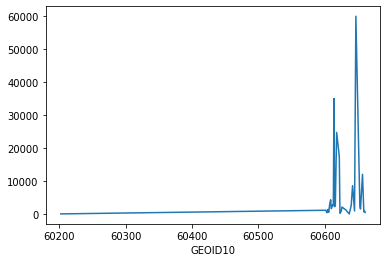

In [22]:
crimes.plot()

/home/malin/.virtualenvs/gsoc/lib/python3.10/site-packages/geoplot/geoplot.py:885: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


<AxesSubplot:>

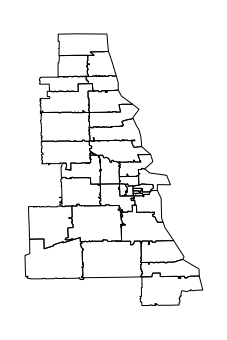

In [23]:
gplt.polyplot(polygons)

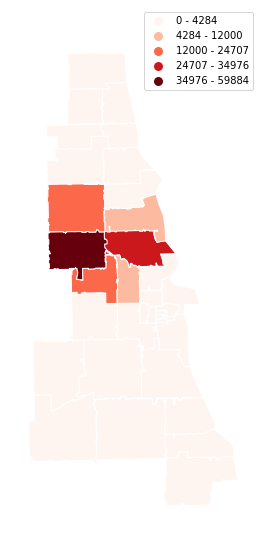

In [24]:
ax = gplt.choropleth(
    polygons, hue=crimes, projection=gcrs.AlbersEqualArea(),
    edgecolor='white', linewidth=1,
    cmap='Reds', legend=True,
    scheme='FisherJenks', figsize=(20,10)
)



<AxesSubplot:>

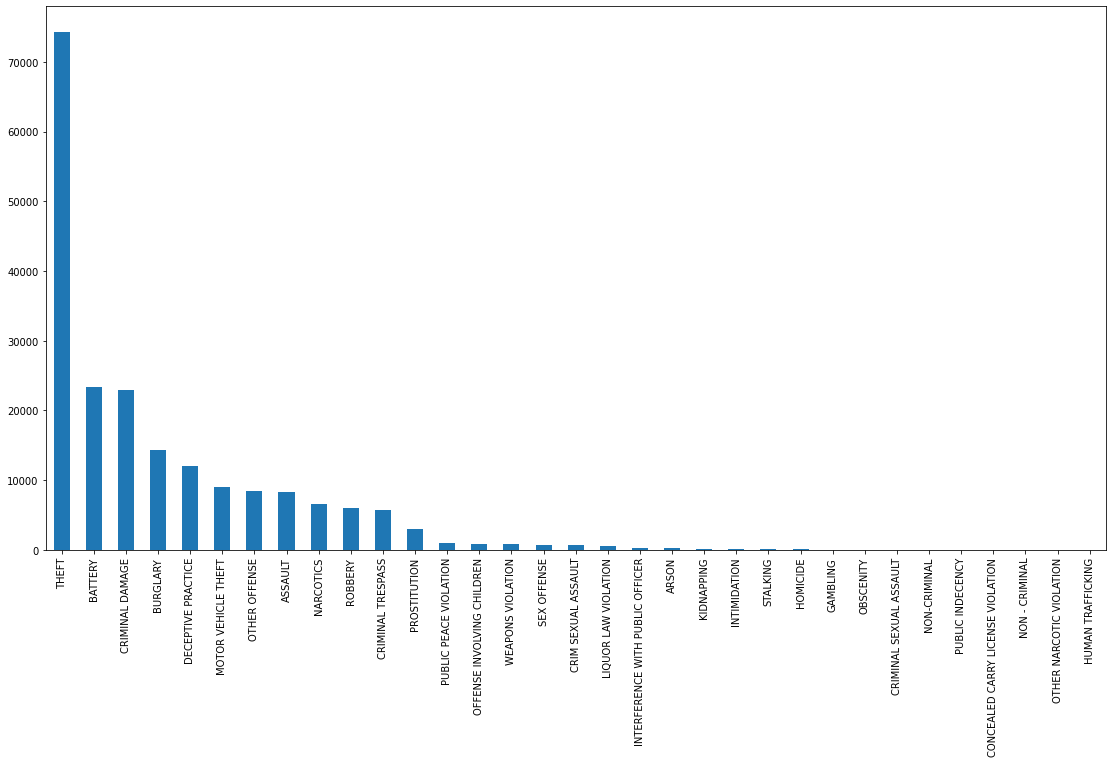

In [25]:
dfCrime['Primary Type'].value_counts().plot.bar(figsize=(19,10))

<AxesSubplot:>

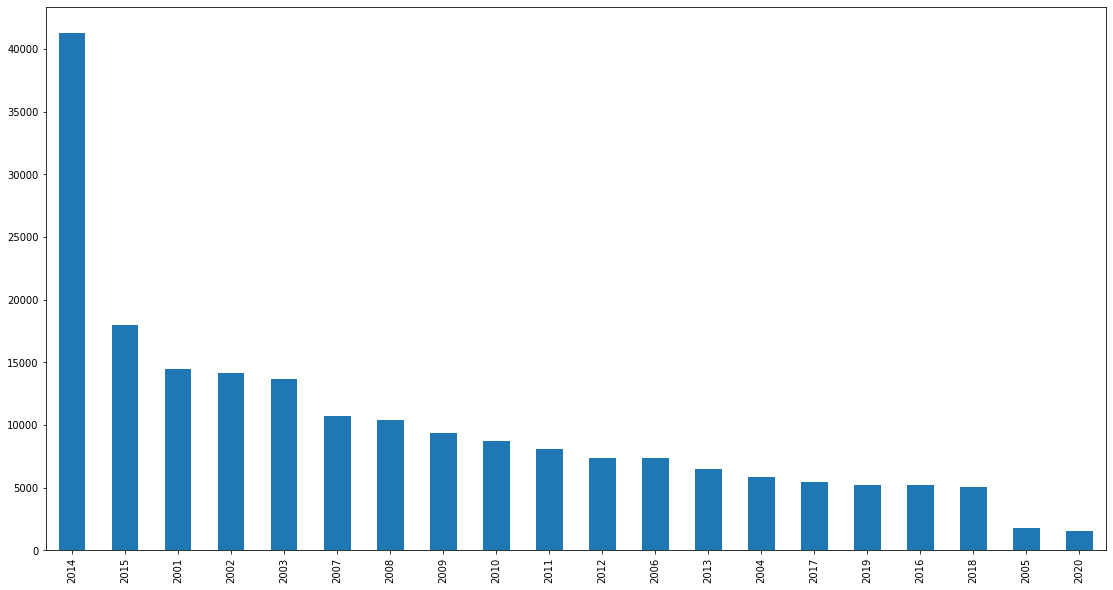

In [26]:
dfCrime['Year'].value_counts().plot.bar(figsize=(19,10))

<AxesSubplot:xlabel='Date'>

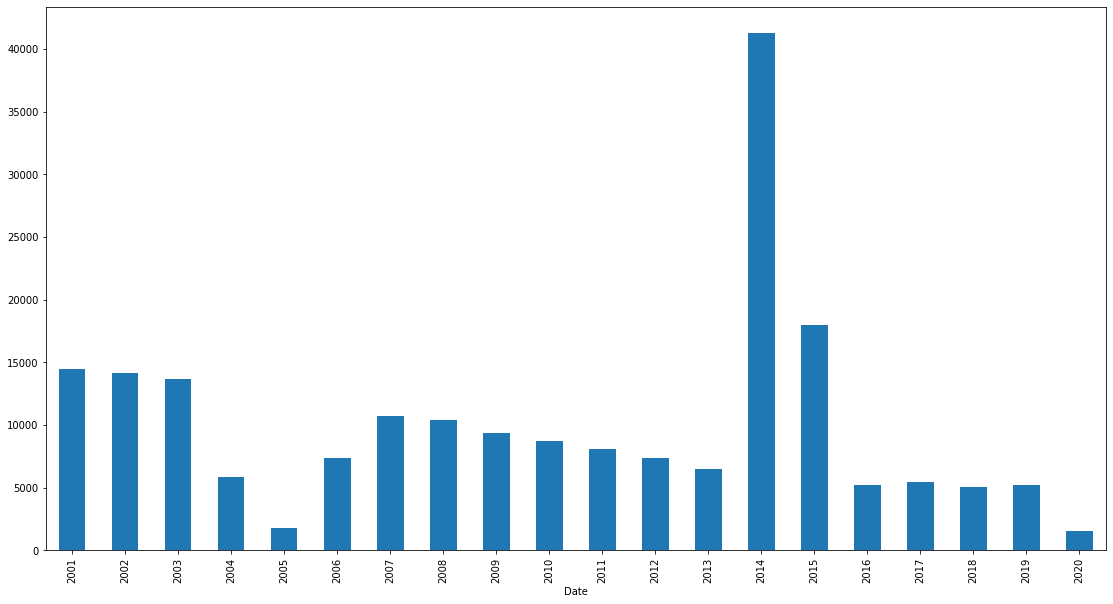

In [27]:
dfCrime['Date'].groupby([dfCrime['Date'].dt.year]).count().plot.bar(figsize=(19,10))